# 概要
- SpanBERT

## setup envirionment

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
    %cd drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/main/
    !pip install  -qq sentencepiece transformers torch==1.9.1 torchvision==0.10.1 torchAudio==0.9.1 torchtext==0.10.1
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/main


Config

In [2]:
class Config:
    name = 'fb_nb012'
    model_savename = 'spanbert'
    
    if ON_KAGGLE:
        model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # base_dir = '/content/drive/MyDrive/petfinder'
        data_dir = '../input/feedback-prize-2021/'
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'
    else:
        # customize for my own Google Colab Environment
        model_name = 'SpanBERT/spanbert-base-cased'
        # model_name = 'allenai/longformer-base-4096' # download from Internet
        base_dir = '/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/'
        data_dir = os.path.join(base_dir, 'input/feedback-prize-2021/')
        pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{name}')
        output_dir = os.path.join(base_dir, f'output/{name}')

    is_debug = False
    load_texts = True
    n_epoch = 15 # not to exceed runtime limits on Kaggle
    n_fold = 5
    verbose_steps = 500
    random_seed = 71
    max_length = 512
    train_batch_size = 4
    valid_batch_size = 4
    lr = 5e-5
    num_labels = 15
    label_subtokens = True
    output_hidden_states = True
    hidden_dropout_prob = 0.1
    layer_norm_eps = 1e-7
    add_pooling_layer = False
    verbose_steps = 500
    if is_debug:
        debug_sample = 1000
        verbose_steps = 16
        n_epoch = 1
        n_fold = 2

constants

In [3]:
IGNORE_INDEX = -100
NON_LABEL = -1
OUTPUT_LABELS = ['0', 'B-Lead', 'I-Lead', 'B-Position', 'I-Position', 'B-Claim', 'I-Claim', 'B-Counterclaim', 'I-Counterclaim', 
                 'B-Rebuttal', 'I-Rebuttal', 'B-Evidence', 'I-Evidence', 'B-Concluding Statement', 'I-Concluding Statement']
LABELS_TO_IDS = {v:k for k,v in enumerate(OUTPUT_LABELS)}
IDS_TO_LABELS = {k:v for k,v in enumerate(OUTPUT_LABELS)}

MIN_THRESH = {
    "I-Lead": 9,
    "I-Position": 5,
    "I-Evidence": 14,
    "I-Claim": 3,
    "I-Concluding Statement": 11,
    "I-Counterclaim": 6,
    "I-Rebuttal": 4,
}

PROB_THRESH = {
    "I-Lead": 0.7,
    "I-Position": 0.55,
    "I-Evidence": 0.65,
    "I-Claim": 0.55,
    "I-Concluding Statement": 0.7,
    "I-Counterclaim": 0.5,
    "I-Rebuttal": 0.55,
}

In [4]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        os.makedirs(Config.model_dir, exist_ok=True)
    if not os.path.exists(Config.output_dir):
        os.makedirs(Config.output_dir, exist_ok=True)

### libraries

In [5]:
# if not ON_KAGGLE:
#     !pip install -qq transformers

In [6]:
# general
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import gc
from collections import defaultdict
# nlp
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
from transformers import (
    LongformerConfig, 
    LongformerModel, 
    LongformerTokenizerFast,
    AutoConfig,
    AutoModel, 
    AutoTokenizer,
    logging)
logging.set_verbosity_warning()
logging.set_verbosity_error()
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('error')

## preprocess
use corrected train.csv

https://www.kaggle.com/nbroad/corrected-train-csv-feedback-prize/notebook

In [7]:
if ON_KAGGLE:
    df_alltrain = pd.read_csv('../input/corrected-train-csv-feedback-prize/corrected_train.csv')
else:
    df_alltrain = pd.read_csv(f'{Config.data_dir}/corrected_train.csv')

In [8]:
def agg_essays(train_flg):
    folder = 'train' if train_flg else 'test'
    names, texts =[], []
    for f in tqdm(list(os.listdir(f'{Config.data_dir}/{folder}'))):
        names.append(f.replace('.txt', ''))
        texts.append(open(f'{Config.data_dir}/{folder}/' + f, 'r').read())
        df_texts = pd.DataFrame({'id': names, 'text': texts})

    df_texts['text_split'] = df_texts.text.str.split()
    print('Completed tokenizing texts.')
    return df_texts

In [9]:
def ner(df_texts, df_train):
    all_entities = []
    for _,  row in tqdm(df_texts.iterrows(), total=len(df_texts)):
        total = len(row['text_split'])
        entities = ['0'] * total

        for _, row2 in df_train[df_train['id'] == row['id']].iterrows():
            discourse = row2['discourse_type']
            list_ix = [int(x) for x in row2['predictionstring'].split(' ')]
            entities[list_ix[0]] = f'B-{discourse}'
            for k in list_ix[1:]: entities[k] = f'I-{discourse}'
        all_entities.append(entities)

    df_texts['entities'] = all_entities
    print('Completed mapping discourse to each token.')
    return df_texts

In [10]:
if not Config.load_texts:    
    def preprocess(df_train = None):
        if df_train is None:
            train_flg = False
        else:
            train_flg = True
        
        df_texts = agg_essays(train_flg)

        if train_flg:
            df_texts = ner(df_texts, df_train)
        return df_texts
    
    alltrain_texts = preprocess(df_alltrain)
    test_texts = preprocess()
    # alltrain_texts.to_pickle('../input/fb-data/alltrain_texts_correct.pkl')
    # test_texts.to_pickle('../input/fb-data/test_texts_correct.pkl')
else:
    alltrain_texts = pd.read_pickle('../input/fb-data/alltrain_texts_correct.pkl')
    test_texts = pd.read_pickle('../input/fb-data/test_texts_correct.pkl')

In [11]:
if Config.is_debug:
    alltrain_texts = alltrain_texts.sample(Config.debug_sample).reset_index(drop=True)
print(len(alltrain_texts))

15594


set seed & split train/test

In [12]:
def seed_everything(seed=Config.random_seed):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

seed_everything()
# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


In [13]:
def split_fold(df_train):
    ids = df_train['id'].unique()
    kf = KFold(n_splits=Config.n_fold, shuffle = True, random_state=Config.random_seed)
    for i_fold, (_, valid_index) in enumerate(kf.split(ids)):
        df_train.loc[valid_index,'fold'] = i_fold
    return df_train

alltrain_texts = split_fold(alltrain_texts)
alltrain_texts.head()

,id,text,text_split,entities,fold
0,F48EF80D2ED3,There are many programs in the world around yo...,"[There, are, many, programs, in, the, world, a...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",0.0
1,F8FB4470A52F,"Dear Senator,\n\n""The Electoral College is a p...","[Dear, Senator,, ""The, Electoral, College, is,...","[0, 0, B-Lead, I-Lead, I-Lead, I-Lead, I-Lead,...",0.0
2,F176A8CF72BB,In my opinion i don't think that is fair. i th...,"[In, my, opinion, i, don't, think, that, is, f...","[B-Position, I-Position, I-Position, I-Positio...",4.0
3,EBDE7FC748A4,Unmasking the Face\n\nThe face on Mars was rea...,"[Unmasking, the, Face, The, face, on, Mars, wa...","[0, 0, 0, B-Position, I-Position, I-Position, ...",3.0
4,F6C40C564E5E,Luke think you should join the seagoing cowboy...,"[Luke, think, you, should, join, the, seagoing...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, B-Claim, I-Clai...",4.0


## dataset

In [14]:
class FeedbackPrizeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, has_labels):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.has_labels = has_labels
    
    def __getitem__(self, index):
        text = self.data['text'][index]
        encoding = self.tokenizer(
            text.split(),
            is_split_into_words = True,
            padding = 'max_length',
            truncation = True,
            max_length = self.max_len
        )
        word_ids = encoding.word_ids()

        # targets
        if self.has_labels:
            word_labels = self.data.entities[index]
            prev_word_idx = None
            labels_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    labels_ids.append(IGNORE_INDEX)
                elif word_idx != prev_word_idx:
                    labels_ids.append(LABELS_TO_IDS[word_labels[word_idx]])
                else:
                    if Config.label_subtokens:
                        labels_ids.append(LABELS_TO_IDS[word_labels[word_idx]])
                    else:
                        labels_ids.append(IGNORE_INDEX)
                prev_word_idx = word_idx
            encoding['labels'] = labels_ids
        # convert to torch.tensor
        item = {k: torch.as_tensor(v) for k, v in encoding.items()}
        word_ids2 = [w if w is not None else NON_LABEL for w in word_ids]
        item['word_ids'] = torch.as_tensor(word_ids2)
        return item

    def __len__(self):
        return self.len

## model

In [15]:
alltrain_texts

,id,text,text_split,entities,fold
0,F48EF80D2ED3,There are many programs in the world around yo...,"[There, are, many, programs, in, the, world, a...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",0.0
1,F8FB4470A52F,"Dear Senator,\n\n""The Electoral College is a p...","[Dear, Senator,, ""The, Electoral, College, is,...","[0, 0, B-Lead, I-Lead, I-Lead, I-Lead, I-Lead,...",0.0
2,F176A8CF72BB,In my opinion i don't think that is fair. i th...,"[In, my, opinion, i, don't, think, that, is, f...","[B-Position, I-Position, I-Position, I-Positio...",4.0
3,EBDE7FC748A4,Unmasking the Face\n\nThe face on Mars was rea...,"[Unmasking, the, Face, The, face, on, Mars, wa...","[0, 0, 0, B-Position, I-Position, I-Position, ...",3.0
4,F6C40C564E5E,Luke think you should join the seagoing cowboy...,"[Luke, think, you, should, join, the, seagoing...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, B-Claim, I-Clai...",4.0
...,...,...,...,...,...
15589,10F4C4CDB76D,Do you think students will have time to do at ...,"[Do, you, think, students, will, have, time, t...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",0.0
15590,19C2D7C5171D,This might be a good way to help stop school s...,"[This, might, be, a, good, way, to, help, stop...","[B-Claim, I-Claim, I-Claim, I-Claim, I-Claim, ...",3.0
15591,0C7C06A6D656,To The Principal:\n\nI believe Policy 1 is app...,"[To, The, Principal:, I, believe, Policy, 1, i...","[0, 0, 0, B-Position, I-Position, I-Position, ...",2.0
15592,1E6835823351,Some schools offer distance learnimg as an opt...,"[Some, schools, offer, distance, learnimg, as,...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",2.0


In [16]:
tmp = alltrain_texts.copy()
tmp['len_text'] = tmp['entities'].apply(len)
tmp

,id,text,text_split,entities,fold,len_text
0,F48EF80D2ED3,There are many programs in the world around yo...,"[There, are, many, programs, in, the, world, a...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",0.0,485
1,F8FB4470A52F,"Dear Senator,\n\n""The Electoral College is a p...","[Dear, Senator,, ""The, Electoral, College, is,...","[0, 0, B-Lead, I-Lead, I-Lead, I-Lead, I-Lead,...",0.0,909
2,F176A8CF72BB,In my opinion i don't think that is fair. i th...,"[In, my, opinion, i, don't, think, that, is, f...","[B-Position, I-Position, I-Position, I-Positio...",4.0,372
3,EBDE7FC748A4,Unmasking the Face\n\nThe face on Mars was rea...,"[Unmasking, the, Face, The, face, on, Mars, wa...","[0, 0, 0, B-Position, I-Position, I-Position, ...",3.0,407
4,F6C40C564E5E,Luke think you should join the seagoing cowboy...,"[Luke, think, you, should, join, the, seagoing...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, B-Claim, I-Clai...",4.0,159
...,...,...,...,...,...,...
15589,10F4C4CDB76D,Do you think students will have time to do at ...,"[Do, you, think, students, will, have, time, t...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",0.0,396
15590,19C2D7C5171D,This might be a good way to help stop school s...,"[This, might, be, a, good, way, to, help, stop...","[B-Claim, I-Claim, I-Claim, I-Claim, I-Claim, ...",3.0,193
15591,0C7C06A6D656,To The Principal:\n\nI believe Policy 1 is app...,"[To, The, Principal:, I, believe, Policy, 1, i...","[0, 0, 0, B-Position, I-Position, I-Position, ...",2.0,177
15592,1E6835823351,Some schools offer distance learnimg as an opt...,"[Some, schools, offer, distance, learnimg, as,...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",2.0,505


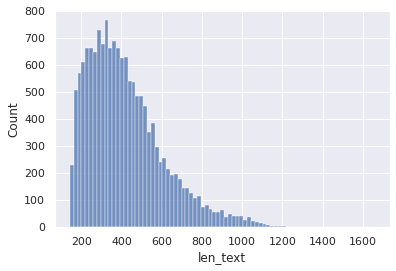

In [17]:
sns.histplot(x='len_text', data=tmp)

In [18]:
tmp[tmp['len_text']>1000].iloc[0,:]

id                                                 EC6294806131
text          Cell Phones and Driving: A Potentially Fatal C...
text_split    [Cell, Phones, and, Driving:, A, Potentially, ...
entities      [0, 0, 0, 0, 0, 0, 0, 0, B-Lead, I-Lead, I-Lea...
fold                                                        2.0
len_text                                                   1049
Name: 59, dtype: object

In [19]:
tmp[tmp['len_text']>1000].iloc[0,:]['text']

'Cell Phones and Driving: A Potentially Fatal Combination\n\nCell phones are a staple in many people\'s lives today. It is a convenient and straightforward way to communicate with someone, gain knowledge, and directly search for information and use for different types of entertainment and media. Everywhere you go, you can see a phone on someone\'s person, and sometimes even on the road. This single action of holding a phone in your hand on the road has a heated debate going on around it. Should this be permitted or not? Let\'s look at the statistics-- The National Highway Traffic Safety Administration (NHTSA 2019) reported 3,166 deaths that occurred in 2017 due to visually distracted driving. That makes up 8.5% of the total fatalities that year (FCC 2019). While this is still less than ten percent, we can make that number a lot lower and spare hundreds of lives each year. These deaths are avoidable.\n\nThe utilization of cell phones in a vehicle while operating should be prohibited in 

In [20]:
class FeedbackModel(nn.Module):
    def __init__(self):
        super(FeedbackModel, self).__init__()
        model_config = AutoConfig.from_pretrained(Config.model_name)
        self.model_config = model_config
        self.backbone = AutoModel.from_pretrained(Config.model_name, config=model_config)
        self.head = nn.Linear(model_config.hidden_size, Config.num_labels)
    
    def forward(self, input_ids, mask):
        x = self.backbone(input_ids, mask)
        logits = self.head(x[0])
        return logits

## utility function

In [21]:
def active_logits(raw_logits, word_ids):
    word_ids = word_ids.view(-1)
    active_mask = word_ids.unsqueeze(1).expand(word_ids.shape[0], Config.num_labels)
    active_mask = active_mask != NON_LABEL
    active_logits = raw_logits.view(-1, Config.num_labels)
    active_logits = torch.masked_select(active_logits, active_mask) # return 1dTensor
    active_logits = active_logits.view(-1, Config.num_labels) 
    return active_logits

def active_labels(labels):
    active_mask = labels.view(-1) != IGNORE_INDEX
    active_labels = torch.masked_select(labels.view(-1), active_mask)
    return active_labels

def active_preds_prob(active_logits):
    active_preds = torch.argmax(active_logits, axis = 1)
    active_preds_prob, _ = torch.max(active_logits, axis = 1)
    return active_preds, active_preds_prob

## evaluating function

In [22]:
def calc_overlap(row):
    """
    calculate the overlap between prediction and ground truth
    """
    set_pred = set(row.new_predictionstring_pred.split(' '))
    set_gt = set(row.new_predictionstring_gt.split(' '))
    # length of each end intersection
    len_pred = len(set_pred)
    len_gt = len(set_gt)
    intersection = len(set_gt.intersection(set_pred))
    overlap_1 = intersection / len_gt
    overlap_2 = intersection / len_pred
    return [overlap_1, overlap_2]

def score_feedback_comp(pred_df, gt_df):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df[['id', 'discourse_type', 'new_predictionstring']].reset_index(drop = True).copy()
    pred_df = pred_df[['id', 'class', 'new_predictionstring']].reset_index(drop = True).copy()
    gt_df['gt_id'] = gt_df.index
    pred_df['pred_id'] = pred_df.index
    joined = pred_df.merge(
        gt_df,
        left_on = ['id', 'class'],
        right_on = ['id', 'discourse_type'],
        how = 'outer',
        suffixes = ['_pred', '_gt']
    )
    joined['new_predictionstring_gt'] =  joined['new_predictionstring_gt'].fillna(' ')
    joined['new_predictionstring_pred'] =  joined['new_predictionstring_pred'].fillna(' ')
    joined['overlaps'] = joined.apply(calc_overlap, axis = 1)
    # overlap over 0.5: true positive
    # If nultiple overlaps exists, the higher is taken.
    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])

    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1', 'overlap2']].max(axis = 1)
    tp_pred_ids = joined.query('potential_TP').sort_values('max_overlap', ascending = False)\
                  .groupby(['id', 'new_predictionstring_gt']).first()['pred_id'].values
    
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]
    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    macro_f1_score = TP / (TP + 1/2 * (FP + FN))
    return macro_f1_score

def oof_score(df_val, oof):
    f1score = []
    classes = ['Lead', 'Position','Claim', 'Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
    for c in classes:
        pred_df = oof.loc[oof['class'] == c].copy()
        gt_df = df_val.loc[df_val['discourse_type'] == c].copy()
        f1 = score_feedback_comp(pred_df, gt_df)
        print(f'{c:<10}: {f1:4f}')
        f1score.append(f1)
    f1avg = np.mean(f1score)
    return f1avg

## inferencing function

In [23]:
def inference(model, dl, criterion, valid_flg):
    final_predictions = []
    final_predictions_prob = []
    stream = tqdm(dl)
    model.eval()
    
    valid_loss = 0
    valid_accuracy = 0
    all_logits = None
    for batch_idx, batch in enumerate(stream, start = 1):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        with torch.no_grad():
            raw_logits = model(input_ids=ids, mask = mask)
        del ids, mask
        
        word_ids = batch['word_ids'].to(device, dtype = torch.long)
        if valid_flg:    
            raw_labels = batch['labels'].to(device, dtype = torch.long)
            logits = active_logits(raw_logits, word_ids)
            labels = active_labels(raw_labels)
            preds, preds_prob = active_preds_prob(logits)
            valid_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            loss = criterion(logits, labels)
            valid_loss += loss.item()
        
        if batch_idx == 1:
            all_logits = raw_logits.cpu().numpy()
        else:
            all_logits = np.append(all_logits, raw_logits.cpu().numpy(), axis=0)

    
    if valid_flg:        
        epoch_loss = valid_loss / batch_idx
        epoch_accuracy = valid_accuracy / batch_idx
    else:
        epoch_loss, epoch_accuracy = 0, 0
    return all_logits, epoch_loss, epoch_accuracy


def preds_class_prob(all_logits, dl):
    print("predict target class and its probabilty")
    final_predictions = []
    final_predictions_score = []
    stream = tqdm(dl)
    len_sample = all_logits.shape[0]

    for batch_idx, batch in enumerate(stream, start=0):
        for minibatch_idx in range(Config.valid_batch_size):
            sample_idx = int(batch_idx * Config.valid_batch_size + minibatch_idx)
            if sample_idx > len_sample - 1 : break
            word_ids = batch['word_ids'][minibatch_idx].numpy()
            predictions =[]
            predictions_prob = []
            pred_class_id = np.argmax(all_logits[sample_idx], axis=1)
            pred_score = np.max(all_logits[sample_idx], axis=1)
            pred_class_labels = [IDS_TO_LABELS[i] for i in pred_class_id]
            prev_word_idx = -1
            for idx, word_idx in enumerate(word_ids):
                if word_idx == -1:
                    pass
                elif word_idx != prev_word_idx:
                    predictions.append(pred_class_labels[idx])
                    predictions_prob.append(pred_score[idx])
                    prev_word_idx = word_idx
            final_predictions.append(predictions)
            final_predictions_score.append(predictions_prob)
    return final_predictions, final_predictions_score

In [24]:
def get_preds_onefold(model, df, dl, criterion, valid_flg):
    logits, valid_loss, valid_acc = inference(model, dl, criterion, valid_flg)
    all_preds, all_preds_prob = preds_class_prob(logits, dl)
    df_pred = post_process_pred(df, all_preds, all_preds_prob)
    return df_pred, valid_loss, valid_acc

def get_preds_folds(df, dl, criterion, valid_flg=False):
    for i_fold in range(Config.n_fold):
        model_filename = os.path.join(Config.model_dir, f"{Config.model_savename}_{i_fold}.bin")
        print(f"{model_filename} inference")
        model = FeedbackModel()
        model = model.to(device)
        model.load_state_dict(torch.load(model_filename))
        logits, valid_loss, valid_acc = inference(model, dl, criterion, valid_flg)
        if i_fold == 0:
            avg_pred_logits = logits
        else:
            avg_pred_logits += logits
    avg_pred_logits /= Config.n_fold
    all_preds, all_preds_prob = preds_class_prob(avg_pred_logits, dl)
    df_pred = post_process_pred(df, all_preds, all_preds_prob)
    return df_pred

def post_process_pred(df, all_preds, all_preds_prob):
    final_preds = []
    for i in range(len(df)):
        idx = df.id.values[i]
        pred = all_preds[i]
        pred_prob = all_preds_prob[i]
        j = 0
        while j < len(pred):
            cls = pred[j]
            if cls == '0': j += 1
            else: cls = cls.replace('B', 'I')
            end = j + 1
            while end < len(pred) and pred[end] == cls:
                end += 1
            if cls != '0' and cls !='':
                avg_score = np.mean(pred_prob[j:end])
                if end - j > MIN_THRESH[cls] and avg_score > PROB_THRESH[cls]:
                    final_preds.append((idx, cls.replace('I-', ''), ' '.join(map(str, list(range(j, end))))))
            j = end
    df_pred = pd.DataFrame(final_preds)
    df_pred.columns = ['id', 'class', 'new_predictionstring']
    return df_pred

## training and validating function

In [25]:
def train_fn(model, dl_train, optimizer, epoch, criterion):
    model.train()
    train_loss = 0
    train_accuracy = 0
    stream = tqdm(dl_train)
    scaler = GradScaler()

    for batch_idx, batch in enumerate(stream, start = 1):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        raw_labels = batch['labels'].to(device, dtype = torch.long)
        word_ids = batch['word_ids'].to(device, dtype = torch.long)
        optimizer.zero_grad()
        with autocast():
            raw_logits = model(input_ids = ids, mask = mask)
        
        logits = active_logits(raw_logits, word_ids)
        labels = active_labels(raw_labels)
        preds, preds_prob = active_preds_prob(logits)
        train_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        
        if batch_idx % Config.verbose_steps == 0:
            loss_step = train_loss / batch_idx
            print(f'Epoch {epoch}/{Config.n_epoch} | {batch_idx:04d} steps: {loss_step}')

    epoch_loss = train_loss / batch_idx
    epoch_accuracy = train_accuracy / batch_idx
    del dl_train, raw_logits, logits, raw_labels, preds, labels
    torch.cuda.empty_cache()
    gc.collect()
    print(f'epoch {epoch} - training loss: {epoch_loss:.4f}')
    print(f'epoch {epoch} - training accuracy: {epoch_accuracy:.4f}')
    return epoch_loss

In [26]:
def valid_fn(model, df_val, df_val_eval, dl_val, epoch, criterion):
    oof, valid_loss, valid_acc  = get_preds_onefold(model, df_val, dl_val, criterion, valid_flg=True)
    f1score =[]
    # classes = oof['class'].unique()
    classes = ['Lead', 'Position', 'Claim','Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
    print(f"Validation F1 scores")

    for c in classes:
        pred_df = oof.loc[oof['class'] == c].copy()
        gt_df = df_val_eval.loc[df_val_eval['discourse_type'] == c].copy()
        f1 = score_feedback_comp(pred_df, gt_df)
        print(f' * {c:<10}: {f1:4f}')
        f1score.append(f1)
    f1avg = np.mean(f1score)
    print(f'Overall Validation avg F1: {f1avg:.4f} val_loss:{valid_loss:.4f} val_accuracy:{valid_acc:.4f}')
    return valid_loss, oof, f1avg

# Early Stopping

In [27]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='checkpoint_model.pth', direction='max'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.path = path             #ベストモデル格納path
        self.direction = direction
        if self.direction == 'max':
            self.val_loss_init = -np.Inf
        elif self.direction == 'min':
            self.val_loss_init = np.Inf

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        if self.direction == 'max':
            self.score = val_loss
        elif self.direction == 'min':
            self.score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = self.score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif self.score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = self.score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            if self.direction == 'max':
                print(f'Validation loss increased ({self.val_loss_init:.6f} --> {val_loss:.6f}).  Saving model ...')
            else:
                print(f'Validation loss decreased ({self.val_loss_init:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する

# Training loop



================================================== Fold0 training ==================================================
------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.2766474609375
Training loss after 1000 training steps: 1.1005263671875
Training loss after 1500 training steps: 1.0081484375
Training loss after 2000 training steps: 0.9475009765625
Training loss after 2500 training steps: 0.9079208984375
Training loss after 3000 training steps: 0.8790419108072917
epoch 1 - training loss: 0.8721
epoch 1 - training accuracy: 0.7295


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.737086
 * Position  : 0.618084
 * Claim     : 0.535323
 * Counterclaim: 0.321487
 * Rebuttal  : 0.229719
 * Evidence  : 0.580324
 * Concluding Statement: 0.551861
Overall Validation avg F1: 0.5106 val_loss:0.7052 val_accuracy:0.7586
Validation loss increased (-inf --> 0.510555).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.65255908203125
Training loss after 1000 training steps: 0.639485595703125
Training loss after 1500 training steps: 0.6378887532552083
Training loss after 2000 training steps: 0.6412305297851563
Training loss after 2500 training steps: 0.640943408203125
Training loss after 3000 training steps: 0.6394209391276041
epoch 2 - training loss: 0.6397
epoch 2 - training accuracy: 0.7839


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.776740
 * Position  : 0.644467
 * Claim     : 0.535700
 * Counterclaim: 0.301754
 * Rebuttal  : 0.202627
 * Evidence  : 0.600192
 * Concluding Statement: 0.558111
Overall Validation avg F1: 0.5171 val_loss:0.6732 val_accuracy:0.7772
Validation loss increased (-inf --> 0.517084).  Saving model ...
------------------------------ Epoch3 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.540640625
Training loss after 1000 training steps: 0.5379132080078125
Training loss after 1500 training steps: 0.5376842447916667
Training loss after 2000 training steps: 0.5437298583984375
Training loss after 2500 training steps: 0.54245546875
Training loss after 3000 training steps: 0.5434659830729167
epoch 3 - training loss: 0.5435
epoch 3 - training accuracy: 0.8137


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.764691
 * Position  : 0.640094
 * Claim     : 0.545701
 * Counterclaim: 0.375183
 * Rebuttal  : 0.289835
 * Evidence  : 0.603786
 * Concluding Statement: 0.563853
Overall Validation avg F1: 0.5404 val_loss:0.7152 val_accuracy:0.7599
Validation loss increased (-inf --> 0.540449).  Saving model ...
------------------------------ Epoch4 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.43805322265625
Training loss after 1000 training steps: 0.4497166748046875
Training loss after 1500 training steps: 0.45243684895833336
Training loss after 2000 training steps: 0.45734405517578125
Training loss after 2500 training steps: 0.459863134765625
Training loss after 3000 training steps: 0.46181599934895834
epoch 4 - training loss: 0.4632
epoch 4 - training accuracy: 0.8393


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.764572
 * Position  : 0.630724
 * Claim     : 0.549943
 * Counterclaim: 0.370079
 * Rebuttal  : 0.263518
 * Evidence  : 0.619460
 * Concluding Statement: 0.569311
Overall Validation avg F1: 0.5382 val_loss:0.7090 val_accuracy:0.7678
EarlyStopping counter: 1 out of 1
Early Stopping!

Epoch4 best f1 score: 0.5404491564083482
================================================== Fold1 training ==================================================
------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.42448828125
Training loss after 1000 training steps: 1.21883203125
Training loss after 1500 training steps: 1.10723193359375
Training loss after 2000 training steps: 1.033273681640625
Training loss after 2500 training steps: 0.9882916015625
Training loss after 3000 training steps: 0.9490284016927083
epoch 1 - training loss: 0.9405
epoch 1 - training accuracy: 0.7089


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.730449
 * Position  : 0.611241
 * Claim     : 0.500377
 * Counterclaim: 0.295852
 * Rebuttal  : 0.082492
 * Evidence  : 0.572356
 * Concluding Statement: 0.556400
Overall Validation avg F1: 0.4785 val_loss:0.7513 val_accuracy:0.7522
Validation loss increased (-inf --> 0.478452).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.66532421875
Training loss after 1000 training steps: 0.6649720458984375
Training loss after 1500 training steps: 0.671022705078125
Training loss after 2000 training steps: 0.6719832153320312
Training loss after 2500 training steps: 0.674342138671875
Training loss after 3000 training steps: 0.6740951334635417
epoch 2 - training loss: 0.6723
epoch 2 - training accuracy: 0.7741


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.753382
 * Position  : 0.638612
 * Claim     : 0.514415
 * Counterclaim: 0.278081
 * Rebuttal  : 0.111221
 * Evidence  : 0.569068
 * Concluding Statement: 0.535749
Overall Validation avg F1: 0.4858 val_loss:0.7024 val_accuracy:0.7614
Validation loss increased (-inf --> 0.485790).  Saving model ...
------------------------------ Epoch3 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.567728271484375
Training loss after 1000 training steps: 0.5662960205078125
Training loss after 1500 training steps: 0.5704459635416667
Training loss after 2000 training steps: 0.567549560546875
Training loss after 2500 training steps: 0.5678
Training loss after 3000 training steps: 0.5701724853515625
epoch 3 - training loss: 0.5699
epoch 3 - training accuracy: 0.8042


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.738557
 * Position  : 0.620206
 * Claim     : 0.504820
 * Counterclaim: 0.323625
 * Rebuttal  : 0.267261
 * Evidence  : 0.580074
 * Concluding Statement: 0.554152
Overall Validation avg F1: 0.5127 val_loss:0.7066 val_accuracy:0.7646
Validation loss increased (-inf --> 0.512671).  Saving model ...
------------------------------ Epoch4 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.46253271484375
Training loss after 1000 training steps: 0.4747672119140625
Training loss after 1500 training steps: 0.4773688151041667
Training loss after 2000 training steps: 0.47536880493164063
Training loss after 2500 training steps: 0.4800042724609375
Training loss after 3000 training steps: 0.48227178955078126
epoch 4 - training loss: 0.4823
epoch 4 - training accuracy: 0.8332


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.768089
 * Position  : 0.628921
 * Claim     : 0.531295
 * Counterclaim: 0.360561
 * Rebuttal  : 0.264168
 * Evidence  : 0.586484
 * Concluding Statement: 0.555112
Overall Validation avg F1: 0.5278 val_loss:0.7601 val_accuracy:0.7535
Validation loss increased (-inf --> 0.527804).  Saving model ...
------------------------------ Epoch5 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.3904979248046875
Training loss after 1000 training steps: 0.39573284912109374
Training loss after 1500 training steps: 0.40109598795572915
Training loss after 2000 training steps: 0.4032070007324219
Training loss after 2500 training steps: 0.4033705810546875
Training loss after 3000 training steps: 0.4050037841796875
epoch 5 - training loss: 0.4061
epoch 5 - training accuracy: 0.8589


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.761167
 * Position  : 0.638468
 * Claim     : 0.531297
 * Counterclaim: 0.360322
 * Rebuttal  : 0.273848
 * Evidence  : 0.592849
 * Concluding Statement: 0.563598
Overall Validation avg F1: 0.5316 val_loss:0.7854 val_accuracy:0.7509
Validation loss increased (-inf --> 0.531650).  Saving model ...
------------------------------ Epoch6 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.3205894775390625
Training loss after 1000 training steps: 0.33305059814453125
Training loss after 1500 training steps: 0.3381966552734375
Training loss after 2000 training steps: 0.3410436096191406
Training loss after 2500 training steps: 0.3441102294921875
Training loss after 3000 training steps: 0.3462013142903646
epoch 6 - training loss: 0.3462
epoch 6 - training accuracy: 0.8805


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.761675
 * Position  : 0.628562
 * Claim     : 0.508448
 * Counterclaim: 0.372701
 * Rebuttal  : 0.281053
 * Evidence  : 0.593107
 * Concluding Statement: 0.557027
Overall Validation avg F1: 0.5289 val_loss:0.8692 val_accuracy:0.7446
EarlyStopping counter: 1 out of 1
Early Stopping!

Epoch6 best f1 score: 0.531649929468584
================================================== Fold2 training ==================================================
------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.3727919921875
Training loss after 1000 training steps: 1.17347412109375
Training loss after 1500 training steps: 1.0729235026041666
Training loss after 2000 training steps: 1.0138209228515624
Training loss after 2500 training steps: 0.97127021484375
Training loss after 3000 training steps: 0.9346110026041666
epoch 1 - training loss: 0.9267
epoch 1 - training accuracy: 0.7109


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.742279
 * Position  : 0.625813
 * Claim     : 0.490859
 * Counterclaim: 0.242925
 * Rebuttal  : 0.055127
 * Evidence  : 0.574562
 * Concluding Statement: 0.563275
Overall Validation avg F1: 0.4707 val_loss:0.7204 val_accuracy:0.7601
Validation loss increased (-inf --> 0.470691).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.67078173828125
Training loss after 1000 training steps: 0.671799072265625
Training loss after 1500 training steps: 0.6689644368489583
Training loss after 2000 training steps: 0.666391357421875
Training loss after 2500 training steps: 0.664161279296875
Training loss after 3000 training steps: 0.66327490234375
epoch 2 - training loss: 0.6637
epoch 2 - training accuracy: 0.7766


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.731636
 * Position  : 0.620372
 * Claim     : 0.520149
 * Counterclaim: 0.350711
 * Rebuttal  : 0.266667
 * Evidence  : 0.590942
 * Concluding Statement: 0.552187
Overall Validation avg F1: 0.5190 val_loss:0.6963 val_accuracy:0.7622
Validation loss increased (-inf --> 0.518952).  Saving model ...
------------------------------ Epoch3 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.5366123046875
Training loss after 1000 training steps: 0.5464188232421875
Training loss after 1500 training steps: 0.5556453450520833
Training loss after 2000 training steps: 0.5593528442382812
Training loss after 2500 training steps: 0.563054345703125
Training loss after 3000 training steps: 0.5642012125651041
epoch 3 - training loss: 0.5650
epoch 3 - training accuracy: 0.8063


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.778437
 * Position  : 0.641497
 * Claim     : 0.524652
 * Counterclaim: 0.332437
 * Rebuttal  : 0.190981
 * Evidence  : 0.600033
 * Concluding Statement: 0.551139
Overall Validation avg F1: 0.5170 val_loss:0.6849 val_accuracy:0.7624
EarlyStopping counter: 1 out of 1
Early Stopping!

Epoch3 best f1 score: 0.5189519245209901
================================================== Fold3 training ==================================================
------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.292703125
Training loss after 1000 training steps: 1.12348779296875
Training loss after 1500 training steps: 1.0293121744791667
Training loss after 2000 training steps: 0.968969482421875
Training loss after 2500 training steps: 0.92491513671875
Training loss after 3000 training steps: 0.893023193359375
epoch 1 - training loss: 0.8862
epoch 1 - training accuracy: 0.7255


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.719405
 * Position  : 0.601164
 * Claim     : 0.524332
 * Counterclaim: 0.300736
 * Rebuttal  : 0.116080
 * Evidence  : 0.593084
 * Concluding Statement: 0.535811
Overall Validation avg F1: 0.4844 val_loss:0.7282 val_accuracy:0.7584
Validation loss increased (-inf --> 0.484373).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.6616513671875
Training loss after 1000 training steps: 0.6527838134765624
Training loss after 1500 training steps: 0.64780078125
Training loss after 2000 training steps: 0.64466015625
Training loss after 2500 training steps: 0.647166796875
Training loss after 3000 training steps: 0.6458205159505208
epoch 2 - training loss: 0.6465
epoch 2 - training accuracy: 0.7819


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.708333
 * Position  : 0.626992
 * Claim     : 0.536192
 * Counterclaim: 0.362828
 * Rebuttal  : 0.259472
 * Evidence  : 0.613531
 * Concluding Statement: 0.516573
Overall Validation avg F1: 0.5177 val_loss:0.6859 val_accuracy:0.7675
Validation loss increased (-inf --> 0.517703).  Saving model ...
------------------------------ Epoch3 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.53931396484375
Training loss after 1000 training steps: 0.5386595458984375
Training loss after 1500 training steps: 0.5410360514322917
Training loss after 2000 training steps: 0.5461271362304687
Training loss after 2500 training steps: 0.54793984375
Training loss after 3000 training steps: 0.5494944254557291
epoch 3 - training loss: 0.5497
epoch 3 - training accuracy: 0.8115


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.747152
 * Position  : 0.633115
 * Claim     : 0.544371
 * Counterclaim: 0.375758
 * Rebuttal  : 0.275698
 * Evidence  : 0.599345
 * Concluding Statement: 0.537596
Overall Validation avg F1: 0.5304 val_loss:0.6835 val_accuracy:0.7711
Validation loss increased (-inf --> 0.530433).  Saving model ...
------------------------------ Epoch4 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.447365234375
Training loss after 1000 training steps: 0.4583519287109375
Training loss after 1500 training steps: 0.46131982421875
Training loss after 2000 training steps: 0.46211819458007813
Training loss after 2500 training steps: 0.4662359619140625
Training loss after 3000 training steps: 0.4667190958658854
epoch 4 - training loss: 0.4670
epoch 4 - training accuracy: 0.8378


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.744186
 * Position  : 0.629446
 * Claim     : 0.533447
 * Counterclaim: 0.352178
 * Rebuttal  : 0.264829
 * Evidence  : 0.578694
 * Concluding Statement: 0.545110
Overall Validation avg F1: 0.5211 val_loss:0.7360 val_accuracy:0.7645
EarlyStopping counter: 1 out of 1
Early Stopping!

Epoch4 best f1 score: 0.5304334566346592
================================================== Fold4 training ==================================================
------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 1.3620703125
Training loss after 1000 training steps: 1.17883837890625
Training loss after 1500 training steps: 1.0763673502604167
Training loss after 2000 training steps: 1.007968994140625
Training loss after 2500 training steps: 0.958771875
Training loss after 3000 training steps: 0.9206687825520833
epoch 1 - training loss: 0.9136
epoch 1 - training accuracy: 0.7168


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.730087
 * Position  : 0.616277
 * Claim     : 0.536134
 * Counterclaim: 0.327064
 * Rebuttal  : 0.172881
 * Evidence  : 0.597699
 * Concluding Statement: 0.547595
Overall Validation avg F1: 0.5040 val_loss:0.7204 val_accuracy:0.7644
Validation loss increased (-inf --> 0.503962).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.65907568359375
Training loss after 1000 training steps: 0.6541494140625
Training loss after 1500 training steps: 0.65824951171875
Training loss after 2000 training steps: 0.659578369140625
Training loss after 2500 training steps: 0.65700703125
Training loss after 3000 training steps: 0.6592131754557292
epoch 2 - training loss: 0.6580
epoch 2 - training accuracy: 0.7791


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.712449
 * Position  : 0.623060
 * Claim     : 0.537105
 * Counterclaim: 0.354786
 * Rebuttal  : 0.266667
 * Evidence  : 0.614856
 * Concluding Statement: 0.535897
Overall Validation avg F1: 0.5207 val_loss:0.7074 val_accuracy:0.7667
Validation loss increased (-inf --> 0.520689).  Saving model ...
------------------------------ Epoch3 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Training loss after 0500 training steps: 0.53654541015625
Training loss after 1000 training steps: 0.5495081787109375
Training loss after 1500 training steps: 0.5579576009114583
Training loss after 2000 training steps: 0.5603384399414062
Training loss after 2500 training steps: 0.561017724609375
Training loss after 3000 training steps: 0.5611502278645834
epoch 3 - training loss: 0.5602
epoch 3 - training accuracy: 0.8085


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.698380
 * Position  : 0.624466
 * Claim     : 0.541393
 * Counterclaim: 0.359939
 * Rebuttal  : 0.259109
 * Evidence  : 0.605519
 * Concluding Statement: 0.541500
Overall Validation avg F1: 0.5186 val_loss:0.7268 val_accuracy:0.7615
EarlyStopping counter: 1 out of 1
Early Stopping!

Epoch3 best f1 score: 0.5206885738430621
elapsed time: 18785.3s


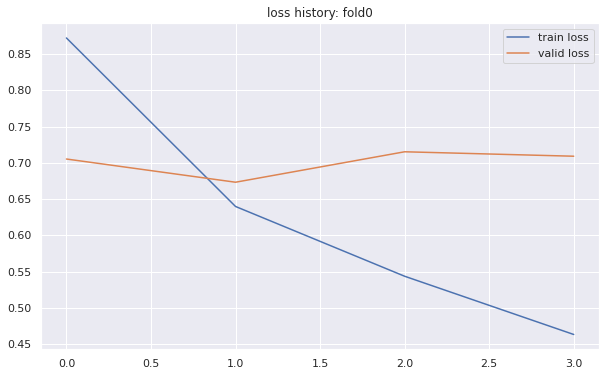

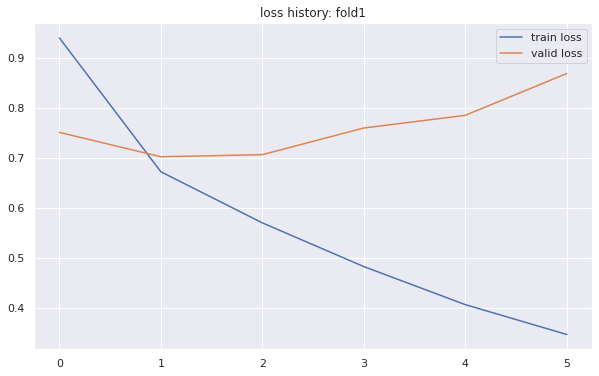

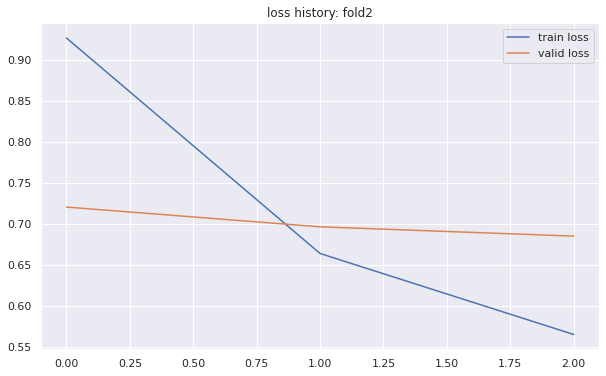

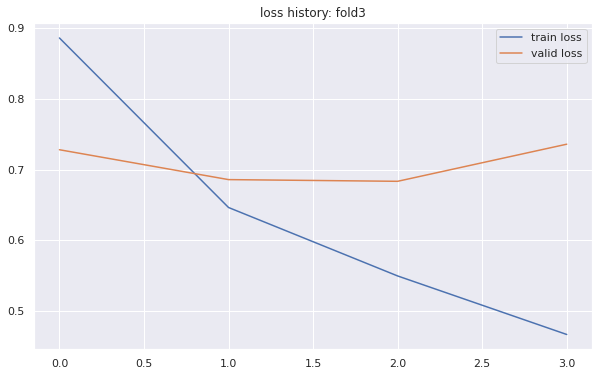

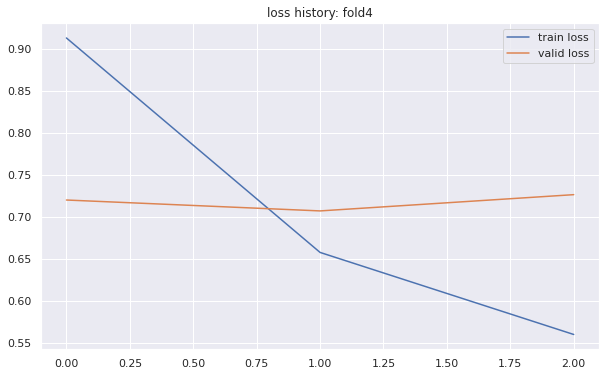

In [29]:
start_time = time.time()

oof = pd.DataFrame()
for i_fold in range(Config.n_fold):
    print('='*50, f'Fold{i_fold} training', '='*50)
    tokenizer = AutoTokenizer.from_pretrained(Config.model_name, add_prefix_space = True)
    model = FeedbackModel()
    model = model.to(device)
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=Config.lr)
    
    df_train = alltrain_texts[alltrain_texts['fold'] != i_fold].reset_index(drop = True)
    ds_train = FeedbackPrizeDataset(df_train, tokenizer, Config.max_length, True)
    df_val = alltrain_texts[alltrain_texts['fold'] == i_fold].reset_index(drop = True)
    val_idlist = df_val['id'].unique().tolist()
    df_val_eval = df_alltrain.query('id==@val_idlist').reset_index(drop=True)
    ds_val = FeedbackPrizeDataset(df_val, tokenizer, Config.max_length, True)
    dl_train = DataLoader(ds_train, batch_size=Config.train_batch_size, shuffle=True, num_workers=2, pin_memory=True)
    dl_val = DataLoader(ds_val, batch_size=Config.valid_batch_size, shuffle=False, num_workers=2, pin_memory=True)

    best_val_loss = np.inf
    criterion = nn.CrossEntropyLoss()

    train_loss_history = []
    valid_loss_history = []
    valid_f1_history = []

    # Early Stopping
    model_filename = f'{Config.model_dir}/{Config.model_savename}_{i_fold}.bin'
    earlystopping = EarlyStopping(patience=1, verbose=True, path=model_filename, direction='max') 

    for epoch in range(1, Config.n_epoch + 1):
        print('-'*30, f'Epoch{epoch}', '-'*30)
        # Training
        train_loss = train_fn(model, dl_train, optimizer, epoch, criterion) # train
        train_loss_history.append(train_loss) # train lossの保存

        # Validation
        valid_loss, _oof, val_f1avg = valid_fn(model, df_val, df_val_eval, dl_val, epoch, criterion) # validation
        valid_loss_history.append(valid_loss) # valid lossの保存
        valid_f1_history.append(val_f1avg) # valid f1の保存

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            _oof_fold_best = _oof
            _oof_fold_best['fold'] = i_fold

        # early stoppingに引っ掛かったらmodelを保存する
        earlystopping(val_f1avg, model) # callメソッド呼び出し
        if earlystopping.early_stop: #ストップフラグがTrueの場合、breakでforループを抜ける
            print("Early Stopping!\n")
            print(f'Epoch{epoch} best f1 score: {np.max(valid_f1_history)}')
            break
    
    # lossの描画
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    sns.lineplot(data=train_loss_history, label='train loss')
    sns.lineplot(data=valid_loss_history, label='valid loss')
    ax.set_title(f'loss history: fold{i_fold}')
    plt.legend();

    oof = pd.concat([oof, _oof_fold_best])
    del df_train, ds_train, df_val, val_idlist, df_val_eval, ds_val, dl_train, dl_val, tokenizer, model, optimizer
    gc.collect()
    torch.cuda.empty_cache()

print('elapsed time:', f'{time.time() - start_time:.1f}s')

In [34]:
oof.head()

,id,class,new_predictionstring,fold
0,F48EF80D2ED3,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,0
1,F48EF80D2ED3,Position,30 31 32 33 34 35,0
2,F48EF80D2ED3,Claim,38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53,0
3,F48EF80D2ED3,Claim,54 55 56 57 58 59,0
4,F48EF80D2ED3,Claim,76 77 78 79 80 81 82,0


In [31]:
oof.to_csv(f'{Config.output_dir}/oof_{Config.name}.csv', index=False)

In [32]:
pd.read_csv(f'{Config.output_dir}/oof_{Config.name}.csv').head()

,id,class,new_predictionstring,fold
0,F48EF80D2ED3,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,0
1,F48EF80D2ED3,Position,30 31 32 33 34 35,0
2,F48EF80D2ED3,Claim,38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53,0
3,F48EF80D2ED3,Claim,54 55 56 57 58 59,0
4,F48EF80D2ED3,Claim,76 77 78 79 80 81 82,0


## cv score

In [33]:
if Config.is_debug:
    idlist = alltrain_texts['id'].unique().tolist()
    df_train = df_alltrain.query('id==@idlist')
else:
    df_train = df_alltrain.copy()
print(f'overall cv score: {oof_score(df_train, oof)}')

Lead      : 0.753684
Position  : 0.636346
Claim     : 0.531246
Counterclaim: 0.333627
Rebuttal  : 0.219955
Evidence  : 0.596942
Concluding Statement: 0.543680
overall cv score: 0.5164970648030415
